Import Libraries and Set random seed for reporducibility

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.transforms import autoaugment, transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import csv
import torch.cuda.amp as amp
from torch.optim.lr_scheduler import CosineAnnealingLR

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu' # Select GPU
print("Using device:", device)

Using device: cuda


Defining Model Architecture

In [ ]:
# BasicBlock with SE Attention
class BasicBlock(nn.Module):
    """
    Enhanced Basic Block with SE (Squeeze-and-Excitation) attention
    """
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3,
            stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3,
            stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        
        # SE attention module
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(planes, planes // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes // 16, planes, kernel_size=1),
            nn.Sigmoid()
        )
        # Shortcut connection for identity mapping
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, planes * self.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(planes * self.expansion)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # First convolution
        out = self.bn2(self.conv2(out)) # Second convolution
        
       
        out = out * self.se(out) # Apply SE attention
        
        out += self.shortcut(x) # Add shortcut connection
        return F.relu(out) # Apply activation


# Define the ResNet Model

class ResNet(nn.Module):
    """
    Improved ResNet with slightly deeper architecture and dropout
    """
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.1):
        super(ResNet, self).__init__()
        self.in_planes = 32
        
        # Initial convolution with more filters
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Deeper layers - slightly increase depth (2,2,2,2)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Add dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # Initial convolution
        out = self.layer1(out) # Apply resnet block
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out) # Global average pooling
        out = out.view(out.size(0), -1) # Flatten
        out = self.dropout(out) # Apply dropout
        out = self.fc(out) # Fully connected output
        return out

def ImprovedResNet():
    """
    Returns an improved ResNet model with increased depth and dropout.
    """    
    return ResNet(BasicBlock, [4,4,4,3], num_classes=10, dropout_rate=0.2)

# Calculate parameter count
model = ImprovedResNet().to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Improved model param count: {num_params:,} (<= 5,000,000)")


# DATA PREPROCESSING AND AUGMENTATION -----------------------------

MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2023, 0.1994, 0.2010]

# Enhanced training transforms with more augmentations
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # Add AutoAugment for CIFAR10
    autoaugment.AutoAugment(policy=autoaugment.AutoAugmentPolicy.CIFAR10),
    # Add random erasing for regularization
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.25)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Use the same datasets but with improved transforms
train_dataset = datasets.CIFAR10(root="./cifar10dataset/cifar10dataset", train=True,
                                download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="./cifar10dataset/cifar10dataset", train=False,
                              download=True, transform=test_transform)

# Train and Test loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

Improved model param count: 4,791,314 (<= 5,000,000)


In [ ]:

#########################################################
# MIXUP AND CUTMIX IMPLEMENTATION
#########################################################

def mixup_data(x, y, alpha=1.0):
    """
    Applies Mixup augmentation to the batch.
    Returns mixed inputs, pairs of targets, and lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    """
    Applies CutMix augmentation to the batch.
    Returns mixed inputs, pairs of targets, and lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    
    # Generate random bounding box
    W, H = x.size(2), x.size(3)
    cut_ratio = np.sqrt(1. - lam)
    cut_w = int(W * cut_ratio)
    cut_h = int(H * cut_ratio)
    
    # Uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    # Boundary conditions
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    # Apply CutMix
    x_cut = x.clone()
    x_cut[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    
    # Adjust lambda to match the actual area
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    
    y_a, y_b = y, y[index]
    return x_cut, y_a, y_b, lam

class LabelSmoothingLoss(nn.Module):
    """
    Label smoothing loss implementation.
    """
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        
    def forward(self, pred, target):
        """
        Args:
            pred: predictions from model (N, C)
            target: target labels (N)
        """
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            # Create one-hot encoding
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# Choose between MixUp, CutMix, or both
USE_MIXUP = True
USE_CUTMIX = True
MIXUP_ALPHA = 1.0
CUTMIX_ALPHA = 1.0
MIXUP_CUTMIX_PROB = 0.5  # Probability of using MixUp vs CutMix when both are enabled

# Enhanced loss function with label smoothing
criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)
criterion_eval = nn.CrossEntropyLoss()  # For evaluation without label smoothing


In [4]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Decide whether to use MixUp, CutMix, or no augmentation for this batch
        do_mixup = USE_MIXUP and (not USE_CUTMIX or np.random.rand() > MIXUP_CUTMIX_PROB)
        do_cutmix = USE_CUTMIX and (not USE_MIXUP or np.random.rand() <= MIXUP_CUTMIX_PROB)
        
        # Apply MixUp or CutMix
        if do_mixup:
            imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, MIXUP_ALPHA)
            
            # Mixed precision training
            with amp.autocast():
                outputs = model(imgs)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
                
        elif do_cutmix:
            imgs, labels_a, labels_b, lam = cutmix_data(imgs, labels, CUTMIX_ALPHA)
            
            # Mixed precision training
            with amp.autocast():
                outputs = model(imgs)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
                
        else:
            # Standard training without mix augmentation
            with amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)
        
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Scale loss and backprop with mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * imgs.size(0)
        
        # For tracking accuracy - these metrics are just approximations when using mixup/cutmix
        _, pred = outputs.max(1)
        if do_mixup or do_cutmix:
            # Approximate accuracy using the dominant label for each mixed sample
            correct_batch = (lam * pred.eq(labels_a).float() + (1 - lam) * pred.eq(labels_b).float()).sum().item()
            correct += correct_batch
        else:
            correct += pred.eq(labels).sum().item()
        
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Improved training hyperparameters
EPOCHS = 200  # Train longer
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)  # Better scheduler

# Initialize mixed precision scaler
scaler = amp.GradScaler()

# Create early stopping
early_stop_patience = 40
early_stop_counter = 0
best_acc = 0.0

# Lists to store metrics
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epoch_times = []

# Training loop with early stopping
for epoch in range(EPOCHS):
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)
    start_time.record()
    
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    scheduler.step()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    end_time.record()
    torch.cuda.synchronize()
    epoch_time = start_time.elapsed_time(end_time) / 1000  # Convert to seconds
    epoch_times.append(epoch_time)
    
    print(f"Epoch [{epoch+1:03d}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
          f"Test Loss: {val_loss:.4f} | Test Acc: {val_acc:.2f}% | Epoch Time: {epoch_time:.2f}s")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print("\nTraining complete!")
print(f"Best Test Accuracy: {best_acc:.2f}%")

/tmp/ipykernel_5463/710763313.py:89: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
/tmp/ipykernel_5463/710763313.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_5463/710763313.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_5463/710763313.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [001/200] Train Loss: 2.0789 | Train Acc: 27.41% || Test Loss: 1.5781 | Test Acc: 52.32% | Epoch Time: 27.95s
Epoch [002/200] Train Loss: 1.8599 | Train Acc: 40.72% || Test Loss: 1.4177 | Test Acc: 61.88% | Epoch Time: 24.26s
Epoch [003/200] Train Loss: 1.7732 | Train Acc: 45.47% || Test Loss: 1.3460 | Test Acc: 63.68% | Epoch Time: 24.01s
Epoch [004/200] Train Loss: 1.6915 | Train Acc: 49.94% || Test Loss: 1.1611 | Test Acc: 73.57% | Epoch Time: 24.38s
Epoch [005/200] Train Loss: 1.6835 | Train Acc: 50.55% || Test Loss: 1.1609 | Test Acc: 73.45% | Epoch Time: 23.98s
Epoch [006/200] Train Loss: 1.6187 | Train Acc: 53.99% || Test Loss: 1.1256 | Test Acc: 73.81% | Epoch Time: 23.98s
Epoch [007/200] Train Loss: 1.6092 | Train Acc: 54.35% || Test Loss: 1.0742 | Test Acc: 76.62% | Epoch Time: 23.85s
Epoch [008/200] Train Loss: 1.5565 | Train Acc: 56.85% || Test Loss: 1.0914 | Test Acc: 76.77% | Epoch Time: 24.04s
Epoch [009/200] Train Loss: 1.5601 | Train Acc: 56.51% || Test Loss: 1.0

In [5]:
torch.save(model.state_dict(), "resnet_model_200epoch_mixcut_final.pth")
print("Model weights saved successfully!")

Model weights saved successfully!


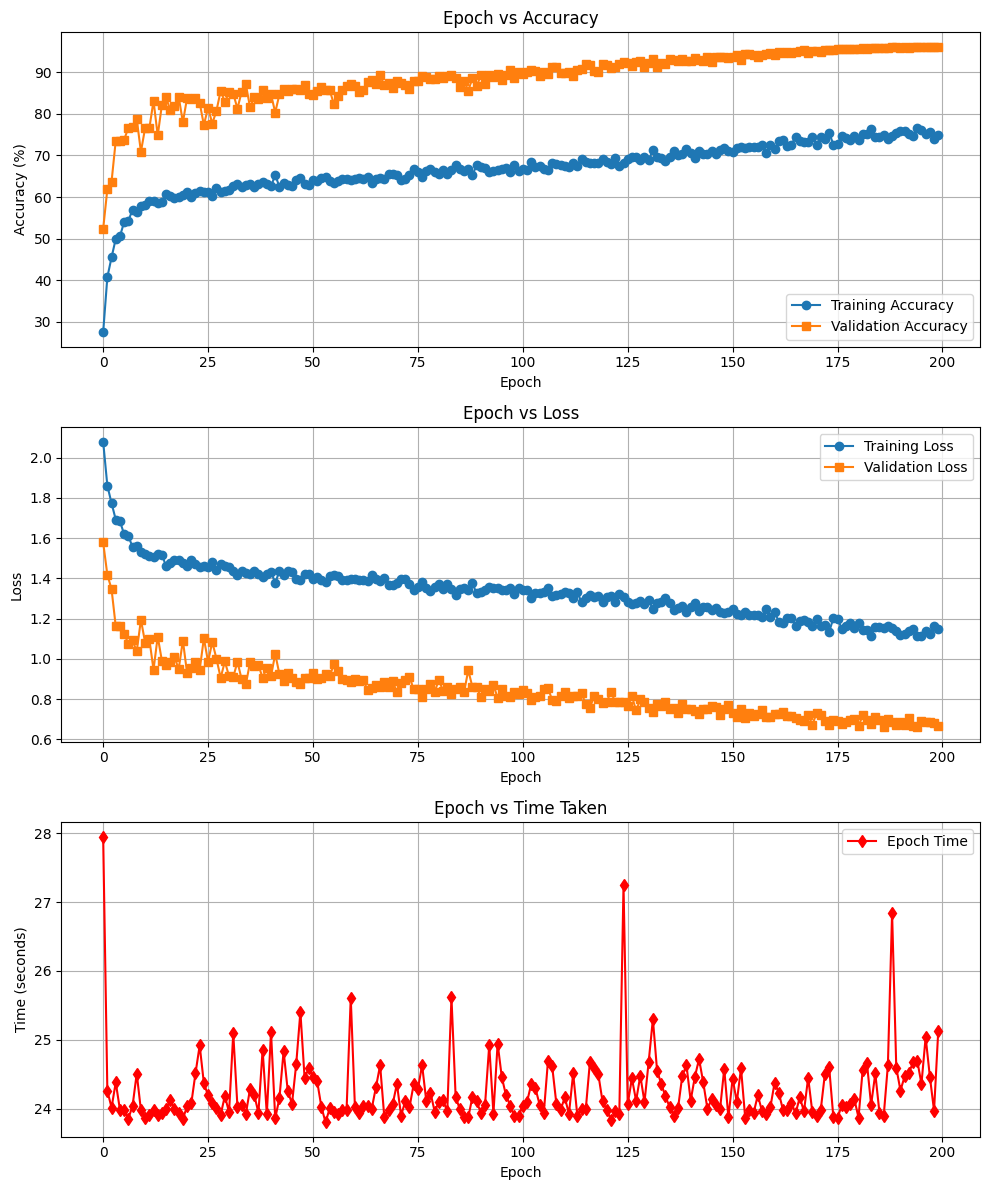

In [6]:
# Plot graphs
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot Train & Validation Accuracy
axs[0].plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", marker='o')
axs[0].plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", marker='s')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("Epoch vs Accuracy")
axs[0].legend()
axs[0].grid()

# Plot Train & Validation Loss
axs[1].plot(range(len(train_losses)), train_losses, label="Training Loss", marker='o')
axs[1].plot(range(len(val_losses)), val_losses, label="Validation Loss", marker='s')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_title("Epoch vs Loss")
axs[1].legend()
axs[1].grid()

# Plot Epoch Time
axs[2].plot(range(len(epoch_times)), epoch_times, label="Epoch Time", marker='d', color='r')
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Time (seconds)")
axs[2].set_title("Epoch vs Time Taken")
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()
